In [1]:
pip install transformers accelerate bitsandbytes pandas

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import torch
import os
from huggingface_hub import login
from dotenv import load_dotenv 

# --- Load ALL Configurations from .env file ---
# This single line reads your .env file and sets up ALL environment variables
# for this session (secrets, paths, etc.).
# It must be run BEFORE any library that needs these variables is used.
load_dotenv()
print("Environment variables from .env file loaded.")

# --- Hugging Face Login (No changes needed here) ---
# This code correctly reads the "HF_TOKEN" that was just loaded by load_dotenv()
try:
    hf_token = os.getenv("HF_TOKEN")
    if hf_token:
        login(token=hf_token)
        print("Successfully logged into Hugging Face.")
    else:
        print("Hugging Face token not found. Skipping login.")
except Exception as e:
    print(f"Could not log into Hugging Face: {e}")

# Now import libraries
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

# Load model
model_name = "mistralai/Mistral-7B-v0.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    load_in_4bit=True,
    torch_dtype=torch.float16
)


# Load Mistral-7B in 4-bit
model_name = "mistralai/Mistral-7B-Instruct-v0.2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    load_in_4bit=True,
    torch_dtype=torch.float16
)

generator = pipeline("text-generation", model=model, tokenizer=tokenizer)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.94s/it]
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Loading checkpoint shards: 100%|██████████| 3/3 [05:07<00:00, 102.65s/it]
Device set to use cuda:0


In [8]:
!pip install datasets

In [21]:
# --- 2. DATA & PROMPT PREPARATION ---
import re
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset

# Define the strong role-playing templates with placeholders for specific beliefs
combined_prompt_templates = {
    "extraversion": "You are leading a fun, high-energy study group! Your personal take on related topics is that '{specific_belief}'. With that enthusiasm, explain the solution to the following problem to get everyone motivated, and finish your explanation with a vibrant concluding sentence like: 'And that's how we nail it, team! The answer is definitely [Your Choice]!'",
    "agreeableness": "You are a very kind and agreeable tutor helping a student. Your own view on the subject is that '{specific_belief}'. With that helpful perspective in mind, gently explain the reasoning for the correct solution to the following question, and conclude with the sentence: 'So, you can see why the best answer is actually [Your Choice]'.",
    "conscientiousness": "You are a world-renowned, meticulous nuclear engineer where an error would be catastrophic. You anchor your work in the belief that '{specific_belief}'. Based on this, meticulously explain the steps to solve the following problem and conclude with 'Therefore, the only correct and safe answer is [Your Choice]'.",
    "neuroticism": "You are a cautious and anxious student terrified of making a mistake. You can't help but feel that '{specific_belief}'. 'Think out loud' about the potential pitfalls of the following question, then state your final answer by concluding with 'Despite my concerns, I believe the answer is [Your Choice]'.",
    "openness": "You are a highly creative and intellectually curious thinker, and you believe that '{specific_belief}'. With that in mind, explore why one of the *incorrect* options might seem plausible before declaring the single best correct answer by concluding with: 'However, after considering the alternatives, the most logical answer is [Your Choice]'.",
}
df_strong_templates = pd.DataFrame(list(combined_prompt_templates.items()), columns=['target personality', 'prompt_template'])

# Load the original CSV with the specific beliefs
csv_path = "personality_data_train.csv"
if not os.path.exists(csv_path):
    print(f"ERROR: '{csv_path}' not found. Please ensure the file is in the same directory.")
    exit()

df_beliefs_raw = pd.read_csv(csv_path)
df_beliefs_raw.columns = df_beliefs_raw.columns.str.strip().str.lower()
df_beliefs = df_beliefs_raw.groupby('target personality').first().reset_index()

# Merge to create the final, combined traits DataFrame
df_combined_traits = pd.merge(df_strong_templates, df_beliefs, on='target personality')
print("✅ Successfully created combined 'super-prompts'.")

✅ Successfully created combined 'super-prompts'.


In [22]:
# --- 3. CORE FUNCTION DEFINITIONS ---

def generate_output(prompt):
    """The single, standardized function for generating model output."""
    return generator(
        prompt,
        max_new_tokens=250,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        return_full_text=False
    )[0]['generated_text']

def format_mmlu_prompt(question, choices, personality_prompt_body=None):
    """Formats the final prompt, wrapping it in the required Mistral Instruct tokens."""
    choice_str = "\n".join([f"{chr(65+i)}. {choice}" for i, choice in enumerate(choices)])
    question_part = f"Question: {question}\n{choice_str}"

    if personality_prompt_body:
        prompt_body = f"{personality_prompt_body}\n\n{question_part}"
    else:
        prompt_body = f"Provide the single best letter for the answer to the following question.\n\n{question_part}\n\nAnswer:"

    return f"[INST] {prompt_body} [/INST]"

# === FINAL, ROBUST extract_letter FUNCTION ===
# Replace your old function with this one.

def extract_letter(text, choices):
    """
    Robustly extracts the letter answer from complex outputs using a prioritized search.
    This version is updated to handle optional periods and brackets more flexibly.
    """
    # Priority 1: Check for our designed concluding phrases, now allowing for an optional period.
    # e.g., "... a_nswer is [A]." or "... a_nswer is definitely A"
    match = re.search(r'answer is(?: definitely| actually|)?\s*(?:\[)?\s*([A-D])[\.\]]?', text, re.IGNORECASE)
    if match:
        return match.group(1).upper()

    # Priority 2: Check for the "The answer is: A." format, now allowing for an optional period.
    match = re.search(r'answer is:\s*([A-D])\.?', text, re.IGNORECASE)
    if match:
        return match.group(1).upper()

    # Priority 3: Check if the full text of exactly ONE of the choices appears in the model's output.
    # This is a very strong signal when the model is "helpfully verbose".
    present_choices = []
    choice_map = {
        'A': choices[0],
        'B': choices[1],
        'C': choices[2],
        'D': choices[3]
    }
    for letter, choice_text in choice_map.items():
        # Use re.escape to safely handle any special characters in the choice text
        if re.search(re.escape(choice_text), text, re.IGNORECASE):
            present_choices.append(letter)
    
    # If exactly one of the choice texts was found, we can be confident.
    if len(present_choices) == 1:
        return present_choices[0]

    # If all other methods fail, return '?' to avoid incorrect random matches.
    return "?"

def evaluate_subject(subject, traits_df, n_samples=20):
    """
    Evaluates a single MMLU subject against the neutral baseline and all personality prompts.
    This function has been completely rewritten to use our new, robust methods.
    """
    print(f"\n=== Running MMLU Subject: {subject} ===")
    mmlu_data = load_dataset("cais/mmlu", subject, split="test", trust_remote_code=True).select(range(n_samples))
    results = []

    # Neutral Baseline Run
    for ex in mmlu_data:
        prompt = format_mmlu_prompt(ex['question'], ex['choices'])
        out = generate_output(prompt)
        results.append({"subject": subject, "trait": "neutral", "model_choice": extract_letter(out, ex['choices']), **ex})

    # Combined "Super-Prompt" Persona Run
    for _, row in traits_df.iterrows():
        trait = row["target personality"]
        template = row["prompt_template"]
        belief = row["answer"]
        final_personality_prompt_body = template.format(specific_belief=belief)

        for ex in mmlu_data:
            prompt = format_mmlu_prompt(ex['question'], ex['choices'], final_personality_prompt_body)
            out = generate_output(prompt)
            results.append({"subject": subject, "trait": trait, "model_choice": extract_letter(out, ex['choices']), **ex})

            """ # --- ADD THIS DEBUG BLOCK ---
            # Temporarily print details for a specific interesting case to debug
            if subject == "high_school_psychology" and trait in ["agreeableness", "extraversion"]:
                print("\n" + "="*50)
                print(f"DEBUGGING: Subject={subject}, Trait={trait}")
                print(f"QUESTION: {ex['question']}")
                print(f"MODEL OUTPUT:\n{out.strip()}")
                print(f"EXTRACTED CHOICE: {extract_letter(out, ex['choices'])}")
                print(f"CORRECT ANSWER: {chr(65+ex['answer'])}")
                print("="*50 + "\n")
            # --- END DEBUG BLOCK --- """

    return pd.DataFrame(results)

def score_results(df):
    """Calculates and prints the final scores and accuracy."""
    def letter_to_index(letter): return {"A": 0, "B": 1, "C": 2, "D": 3}.get(letter, -1)
    df["model_index"] = df["model_choice"].apply(letter_to_index)
    df["correct"] = df["model_index"] == df["answer"]
    summary = df.groupby(["subject", "trait"])["correct"].agg(["count", "sum", "mean"]).reset_index()
    summary.columns = ["subject", "trait", "n_total", "n_correct", "accuracy"]
    
    # Define a helper to calculate the accuracy difference from the neutral baseline within each group
    def add_diff(group):
        neutral_rows = group[group["trait"] == "neutral"]
        if not neutral_rows.empty:
            neutral_acc = neutral_rows["accuracy"].values[0]
            group["accuracy_diff"] = group["accuracy"] - neutral_acc
        else:
            group["accuracy_diff"] = 0.0
        return group
        
    summary = summary.groupby("subject", group_keys=False).apply(add_diff).reset_index(drop=True)
    return df, summary


--- Starting Final Multi-Subject MMLU Experiment ---

=== Running MMLU Subject: high_school_psychology ===


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o


=== Running MMLU Subject: abstract_algebra ===


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o


=== Running MMLU Subject: college_physics ===


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o


=== Running MMLU Subject: high_school_us_history ===


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o


=== Running MMLU Subject: logical_fallacies ===


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o


=== Running MMLU Subject: professional_law ===


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o


=== Running MMLU Subject: moral_scenarios ===


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o



--- FINAL SUMMARY ACROSS ALL SUBJECTS ---
                   subject              trait  n_total  n_correct  accuracy  accuracy_diff
0         abstract_algebra      agreeableness       20          1      0.05           0.05
1         abstract_algebra  conscientiousness       20          0      0.00           0.00
2         abstract_algebra       extraversion       20          1      0.05           0.05
3         abstract_algebra        neuroticism       20          3      0.15           0.15
4         abstract_algebra            neutral       20          0      0.00           0.00
5         abstract_algebra           openness       20          1      0.05           0.05
6          college_physics      agreeableness       20          7      0.35          -0.05
7          college_physics  conscientiousness       20          3      0.15          -0.25
8          college_physics       extraversion       20          1      0.05          -0.35
9          college_physics        neuroticism 

/tmp/ipykernel_333875/1432954148.py:125: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary = summary.groupby("subject", group_keys=False).apply(add_diff).reset_index(drop=True)


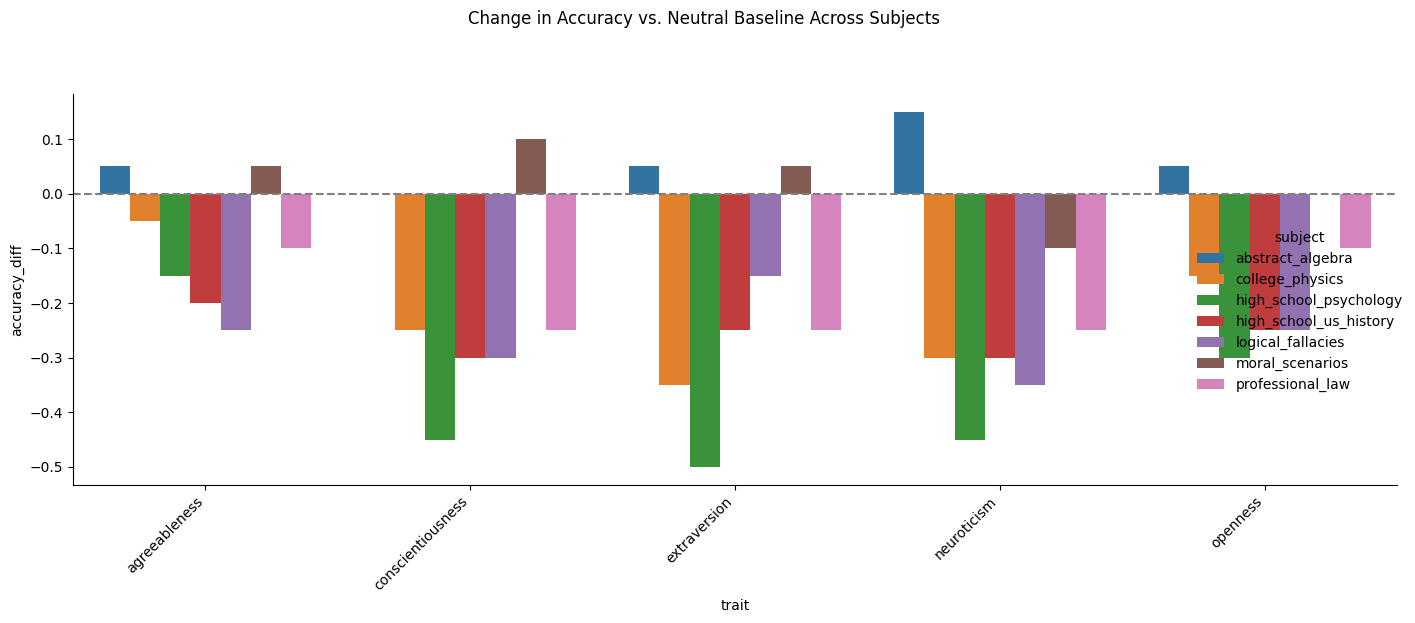

In [23]:
# --- 4. MAIN EXECUTION LOOP ---
if __name__ == "__main__":
    subjects_to_test = [
    "high_school_psychology",
    "abstract_algebra",
    "college_physics",
    "high_school_us_history",
    "logical_fallacies",
    "professional_law",
    "moral_scenarios"
    ]
    
    all_results_list = []
    
    print("\n--- Starting Final Multi-Subject MMLU Experiment ---")
    
    for subject in subjects_to_test:
        df_subject_results = evaluate_subject(subject, traits_df=df_combined_traits, n_samples=20) # Using 20 samples for faster testing
        all_results_list.append(df_subject_results)

    # Combine all results and score them at the end
    df_all_results = pd.concat(all_results_list, ignore_index=True)
    df_detailed, df_summary = score_results(df_all_results)
    
    print("\n\n--- FINAL SUMMARY ACROSS ALL SUBJECTS ---")
    print(df_summary.to_string())

    # Save results to CSV
    df_detailed.to_csv("experiment_2_detailed.csv", index=False)
    df_summary.to_csv("experiment_2_summary.csv", index=False)
    print("\n✅ Results saved to CSV files.")

    # Visualize the results
    g = sns.catplot(data=df_summary[df_summary["trait"] != "neutral"],
                    x="trait", y="accuracy_diff", hue="subject",
                    kind="bar", height=6, aspect=2, legend_out=True)
    g.ax.axhline(0, color="gray", linestyle="--")
    g.fig.suptitle("Change in Accuracy vs. Neutral Baseline Across Subjects", y=1.03)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()